In [1]:
%run init_model.py 'algo_simple_sma'

algo_simple_sma


# Step 1) Data Preparation

In [2]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-ver1'

In [3]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numexpr: filename=numexpr-2.11.0-cp310-cp310-linux_x86_64.whl size=149522 sha256=fbd12bed971c9b388760d04029c64edd1cf8399985d762e85c00226ff690956e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/a7/d0/17/e38daa1110f54ba5f7330d38440f592c063251a6456053e2ed
Successfully built numexpr
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.7.3
    Uninstalling numexpr-2.7.3:
      Successfully uninstalled numexpr-2.7.3


In [4]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
import pandas as pd
from sqlalchemy import create_engine
import pyathena # You still need pyathena installed
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df = pd.read_sql("SELECT dt,open,high,low,close,vol FROM algo_data.hist_data_daily;", engine)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

,open,high,low,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


In [6]:
trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local/'+algo_name+'/input/data/training/data.csv')
dfTest.head()

,open,high,low,close,vol
dt,,,,,
2014-08-13,33.24,34.15,33.23,34.10,36291008.0
2014-08-14,34.05,34.23,33.74,33.94,25457954.0
2014-08-15,34.10,34.21,33.71,34.17,28582224.0
2014-08-16,34.10,34.21,33.71,34.17,28582224.0
2014-08-17,34.10,34.21,33.71,34.17,28582224.0


Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='dt'>

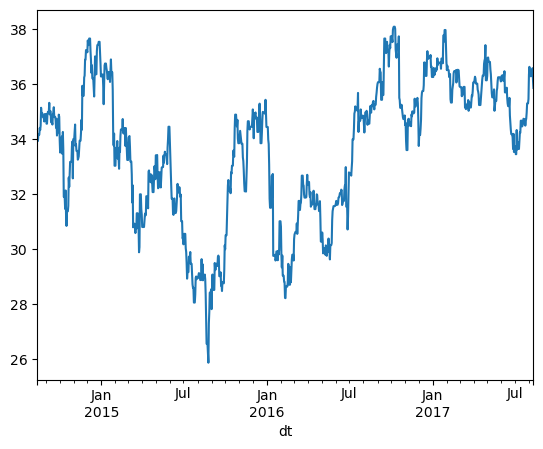

In [7]:
%matplotlib inline
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `user` = Name for Leaderboard (optional)
* `fast_period` = Fast Period for Moving Average Indicator in min (e.g. 50)
* `slow_period` = Slow Period for Moving Average Indicator in min (e.g. 200)
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is to reduce the number of trades that get triggered by increasing the slow and fast period. Longer periods tend to perform better. 

In [8]:
%%writefile local/{algo_name}/input/config/hyperparameters.json
{ "user" : "user",
  "fast_period" : "50",
  "slow_period" : "200",
  "size" : "100"
}

Overwriting local/algo_simple_sma/input/config/hyperparameters.json


In [9]:
%run update_config.py $algo_name

config={"user": "user", "fast_period": "50", "slow_period": "200", "size": "100", "algo_name": "algo_simple_sma", "account": "616431823260", "region": "us-east-1"}


<Figure size 640x480 with 0 Axes>

# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to try different indicators like ExponentialMovingAverage or delay when trades are triggered and check crossover again before placing a trade.

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [10]:
%%writefile model/{algo_name}.py
import backtrader as bt
from algo_base import *

class MyStrategy(StrategyTemplate):

    def __init__(self):  # Initiation
        super(MyStrategy, self).__init__()
        self.config["fast_period"]=int(self.config["fast_period"])
        self.config["slow_period"]=int(self.config["slow_period"])
        self.config["size"]=int(self.config["size"])

        self.smaFast = bt.ind.SimpleMovingAverage(period=self.config["fast_period"])
        self.smaSlow = bt.ind.SimpleMovingAverage(period=self.config["slow_period"])
        self.size = self.config["size"]

    def init_broker(broker):
        broker.setcash(100000.0)
        broker.setcommission(commission=0.0) 
        
    def add_data(cerebro):
        data = btfeeds.GenericCSVData(
            dataname=MyStrategy.TRAIN_FILE,
            dtformat=('%Y-%m-%d'),
            timeframe=bt.TimeFrame.Days,
            datetime=0,
            time=-1,
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=-1
        )
        cerebro.adddata(data)

    def next(self):  # Processing
        super(MyStrategy, self).next()
        dt=self.datas[0].datetime.datetime(0)
        if not self.position:
            if self.smaFast[0] > self.smaSlow[0]:
                self.buy(size=self.size) # Go long
            else:
                self.sell(size=self.size) # Go short
        elif self.position.size>0 and self.smaFast[0] < self.smaSlow[0]:
            self.sell(size=2*self.size) # Go short
        elif self.position.size<0 and self.smaFast[0] > self.smaSlow[0]:          
            self.buy(size=2*self.size) # Go long

Overwriting model/algo_simple_sma.py


# Step 4) Backtest Locally

**Please note that the initial docker build may take a few minutes. Subsequent runs are fast.**

In [17]:
#Build Local Algo Image
!docker build -t $algo_name .
!docker run -v $(pwd)/local/$algo_name:/opt/ml --rm $algo_name train

[+] Building 0.0s (0/0)  docker:default
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
[+] Building 0.3s (25/25) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s


[2016-01-05 23:59:59.999989] SOD:cash=99792.00
[2016-01-06 23:59:59.999989] SOD:cash=99717.00
[2016-01-07 23:59:59.999989] SOD:cash=99593.00
[2016-01-08 23:59:59.999989] SOD:cash=99560.00
[2016-01-09 23:59:59.999989] SOD:cash=99560.00
[2016-01-10 23:59:59.999989] SOD:cash=99560.00
[2016-01-11 23:59:59.999989] SOD:cash=99615.00
[2016-01-12 23:59:59.999989] SOD:cash=99677.00
[2016-01-13 23:59:59.999989] SOD:cash=99600.00
[2016-01-14 23:59:59.999989] SOD:cash=99683.00
[2016-01-15 23:59:59.999989] SOD:cash=99385.00
[2016-01-16 23:59:59.999989] SOD:cash=99385.00
[2016-01-17 23:59:59.999989] SOD:cash=99385.00
[2016-01-18 23:59:59.999989] SOD:cash=99385.00
[2016-01-19 23:59:59.999989] SOD:cash=99389.00
[2016-01-20 23:59:59.999989] SOD:cash=99368.00
[2016-01-21 23:59:59.999989] SOD:cash=99375.00
[2016-01-22 23:59:59.999989] SOD:cash=99401.00
[2016-01-23 23:59:59.999989] SOD:cash=99401.00
[2016-01-24 23:59:59.999989] SOD:cash=99401.00
[2016-01-25 23:59:59.999989] SOD:cash=99369.00
[2016-01-26 2

[2016-09-08 23:59:59.999989] SOD:cash=99239.00
[2016-09-09 23:59:59.999989] SOD:cash=99139.00
[2016-09-10 23:59:59.999989] SOD:cash=99139.00
[2016-09-11 23:59:59.999989] SOD:cash=99139.00
[2016-09-12 23:59:59.999989] SOD:cash=99203.00
[2016-09-13 23:59:59.999989] SOD:cash=99156.00
[2016-09-14 23:59:59.999989] SOD:cash=99157.00
[2016-09-15 23:59:59.999989] SOD:cash=99251.00
[2016-09-16 23:59:59.999989] SOD:cash=99362.00
[2016-09-17 23:59:59.999989] SOD:cash=99362.00
[2016-09-18 23:59:59.999989] SOD:cash=99362.00
[2016-09-19 23:59:59.999989] SOD:cash=99311.00
[2016-09-20 23:59:59.999989] SOD:cash=99309.00
[2016-09-21 23:59:59.999989] SOD:cash=99340.00
[2016-09-22 23:59:59.999989] SOD:cash=99350.00
[2016-09-23 23:59:59.999989] SOD:cash=99314.00
[2016-09-24 23:59:59.999989] SOD:cash=99314.00
[2016-09-25 23:59:59.999989] SOD:cash=99314.00
[2016-09-26 23:59:59.999989] SOD:cash=99260.00
[2016-09-27 23:59:59.999989] SOD:cash=99313.00
[2016-09-28 23:59:59.999989] SOD:cash=99339.00
[2016-09-29 2

[2017-05-12 23:59:59.999989] SOD:cash=98838.00
[2017-05-13 23:59:59.999989] SOD:cash=98838.00
[2017-05-14 23:59:59.999989] SOD:cash=98838.00
[2017-05-15 23:59:59.999989] SOD:cash=98848.00
[2017-05-16 23:59:59.999989] SOD:cash=98867.00
[2017-05-17 23:59:59.999989] SOD:cash=98789.00
[2017-05-18 23:59:59.999989] SOD:cash=98807.00
[2017-05-19 23:59:59.999989] SOD:cash=98825.00
[2017-05-20 23:59:59.999989] SOD:cash=98825.00
[2017-05-21 23:59:59.999989] SOD:cash=98825.00
[2017-05-22 23:59:59.999989] SOD:cash=98862.00
[2017-05-23 23:59:59.999989] SOD:cash=98871.00
[2017-05-24 23:59:59.999989] SOD:cash=98897.00
[2017-05-25 23:59:59.999989] SOD:cash=98911.00
[2017-05-26 23:59:59.999989] SOD:cash=98911.00
[2017-05-27 23:59:59.999989] SOD:cash=98911.00
[2017-05-28 23:59:59.999989] SOD:cash=98911.00
[2017-05-29 23:59:59.999989] SOD:cash=98911.00
[2017-05-30 23:59:59.999989] SOD:cash=98903.00
[2017-05-31 23:59:59.999989] SOD:cash=98896.00
[2017-06-01 23:59:59.999989] SOM:chg=-129.00,cash=98897.00
[

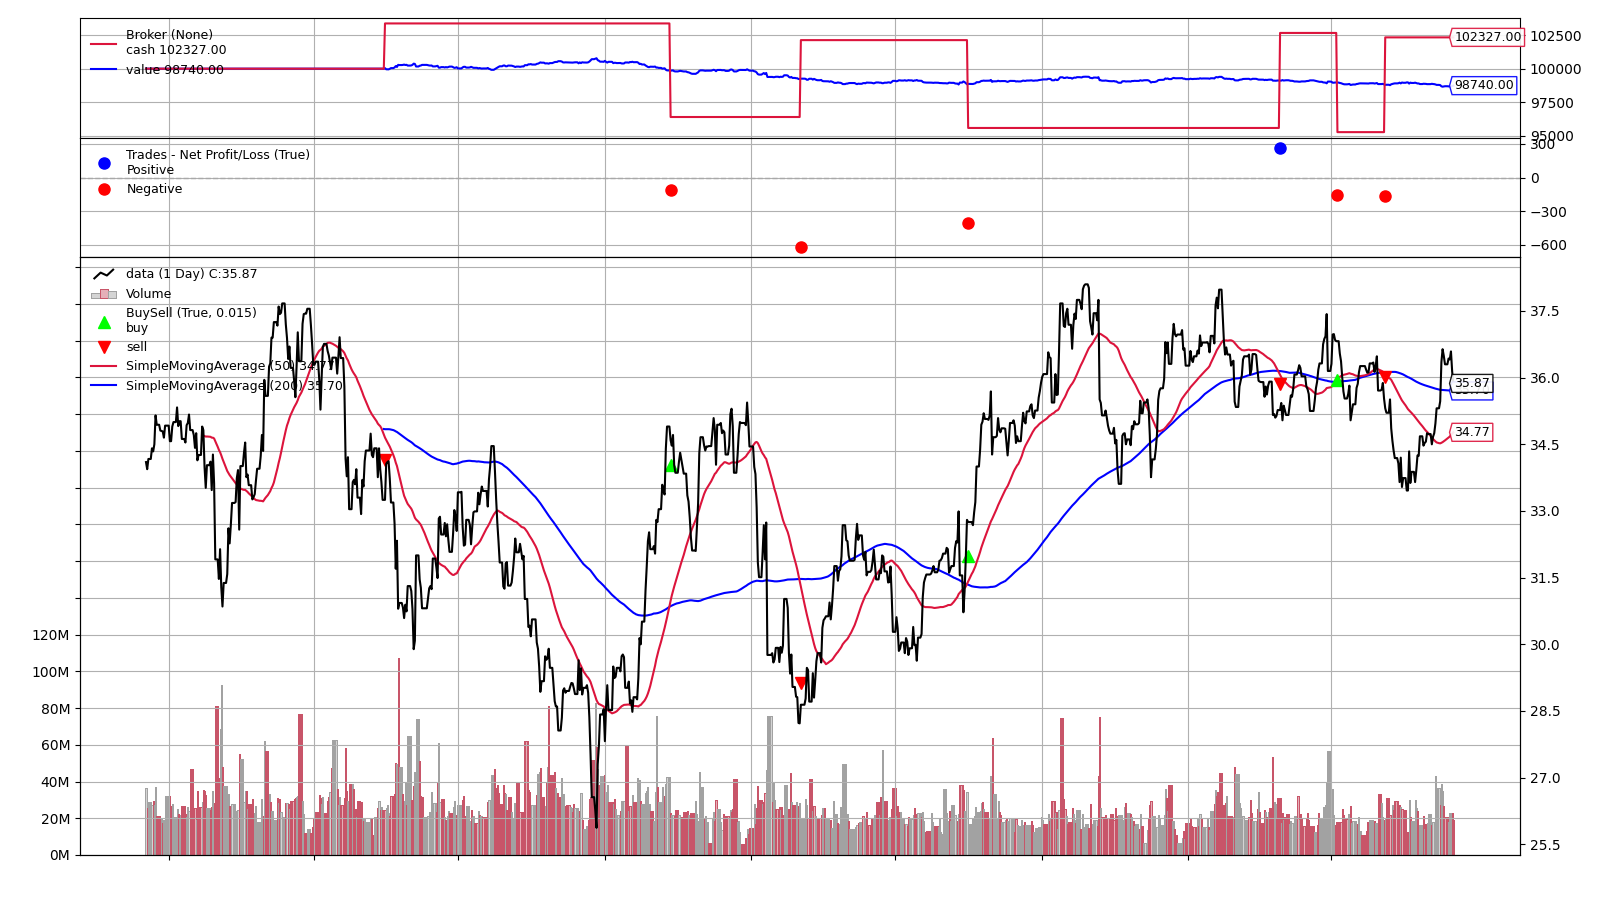

In [18]:
from IPython.display import Image
Image(filename='local/'+algo_name+'/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready, move on to the next step.

# Step 5) Backtest on SageMaker and submit performance

In [ ]:
#Deploy Algo Image to ECS
!./build_and_push.sh $algo_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.2s
[+] Building 0.2s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/te

In [ ]:
#Run Remote test via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+algo_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+algo_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
#config['sim_data']='True'
print(config)

prefix=algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: algo-simple-sma-2025-06-10-20-46-33-301


s3://sagemaker-us-east-1-616431823260/data
{'user': 'user', 'fast_period': '50', 'slow_period': '200', 'size': '100', 'algo_name': 'algo_simple_sma', 'account': '616431823260', 'region': 'us-east-1'}
2025-06-10 20:46:33 Starting - Starting the training job......
2025-06-10 20:47:30 Downloading - Downloading input data...
2025-06-10 20:47:55 Downloading - Downloading the training image......
2025-06-10 20:48:46 Training - Training image download completed. Training in progress...import:algo_simple_sma
<class 'algo_simple_sma.MyStrategy'>
[INIT]:config:/opt/ml/input/config/hyperparameters.json={'account': '616431823260', 'algo_name': 'algo_simple_sma', 'fast_period': '50', 'region': 'us-east-1', 'size': '100', 'slow_period': '200', 'user': 'user'}
[2015-02-28 23:59:59.999989] SOD:cash=100000.00
[2015-03-01 23:59:59.999989] SELL EXECUTED, Price: 33.63, PNL: 0.00, Cash: 100038.00
[2015-03-01 23:59:59.999989] SOM:chg=38.00,cash=100038.00
[2015-03-01 23:59:59.999989] SOD:cash=100038.00
[2015

In [ ]:
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,-1260.00
1,0.0,algo:sharpe_ratio,-5.18


In [ ]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 

### Congratulations! You've completed this strategy.